In [1]:
import sys
import os
import json
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from src.parse_lipid import parse_lipid

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm, ListedColormap
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Tahoma']
plt.style.use('seaborn-white')  # 'seaborn-ticks'
sns.set_style('white')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import linkage

In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

colors['Fasted'] = colors['FBG']
colors['Random-fed'] = colors['RBG']
colors['Fed'] = colors['RBG']
colors['Fasted'] = colors['FBG']

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
# data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

## Stem plots of feature importance (normalized between 0 and 1) for each of the models
## Rank the top 10 or 20 features by the best performing method (OLS) 
### Within each feature, separate into 4 stem lines, one for each model

### Models to use:
    1. OLS
    2. LASSO 
    3. PLS
    4. RF
    5. Individual linear regression (ranks from q-values of fit)
    - Skip SVM and Ridge because within our data they are identical to OLS

In [10]:
r = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv', index_col=0)
r = r.loc[(r['y'] == 'ogtt') & (r['model'].isin(['ols', 'lasso', 'pls', 'rf']))].drop('y', axis=1)
cols = ['model', 'x']
cols.extend(data.index)
r = r[cols]
r['i'] = r['model'] + '_' + r['x']
new_cols = r['i']
r = r.drop(['model', 'x'], axis=1)
r = r.set_index('i').T.abs()
# r = r.loc[data['ID'] != 'unknown']  # only use IDs
r = r.loc[(data['Type'] == 'lipid') & (data['ID'] != 'unknown')]
r.loc[:, :] = MinMaxScaler().fit_transform(r)  # perform 0 to 1 scaling of absolute value of coefficients
r = r.join(data)
r = r.sort_values('ols_Fed', ascending=False).iloc[:20]
r['y_point'] = range(len(r))  # range(len(r), 0, -1)
r

,ols_Fed,ols_Fasted,lasso_Fed,lasso_Fasted,pls_Fed,pls_Fasted,rf_Fed,rf_Fasted,unique_id,RT,...,model_param_sampling[T.RBG]:ogtt,qval_fed,qval_fasted,pval_fed,coef_fed,intercept_fed,pval_fasted,coef_fasted,intercept_fasted,y_point
l_393,1.000000,0.147137,1.000000,0.000000,0.879480,0.207512,0.288816,0.006868,SM d37:1_9.972_745.62457,9.972,...,0.000025,1.299717e-06,0.859076,2.248345e-08,0.000027,19.837326,7.371376e-01,1.670206e-06,20.998183,0
l_800,0.947691,0.950746,0.000154,0.179898,1.000000,0.856751,0.023483,0.099671,CE 18:1_18.03_668.63452,18.030,...,0.000006,1.705471e-02,0.011792,6.819615e-03,-0.000018,23.876763,8.497846e-04,-2.487421e-05,24.150576,1
l_150,0.943566,0.321526,0.164611,0.000000,0.845723,0.236479,0.059650,0.003755,PC 38:7_7.784_804.55353,7.784,...,-0.000029,4.140169e-03,0.564884,1.280367e-03,-0.000022,22.864689,3.513038e-01,6.142960e-06,21.046793,2
l_461,0.915085,1.000000,0.575630,1.000000,0.681705,1.000000,0.106451,0.107406,Plasmanyl-PC O-20:0_20:4_11.065_824.6543,11.065,...,0.000009,2.803017e-05,0.002260,2.424432e-06,0.000033,19.384031,6.779952e-05,2.457437e-05,19.858545,3
l_159,0.865880,0.227458,0.069505,0.000000,0.798246,0.287128,0.086371,0.003542,SM d36:3_7.927_727.57532,7.927,...,0.000014,1.325921e-04,0.579239,1.678907e-05,0.000018,19.498985,3.689582e-01,3.474289e-06,20.365944,4
l_604,0.745705,0.436941,0.046249,0.000000,0.748483,0.539265,0.231667,0.100323,TG 18:1_22:6_22:6_14.916_999.74011,14.916,...,0.000049,6.930232e-07,0.034830,5.695303e-09,0.000071,18.993668,4.009055e-03,2.178789e-05,21.927606,5
l_750,0.739448,0.209447,0.077058,0.000000,0.517589,0.358360,0.026311,0.012185,TG 58:7_17.213_950.8175,17.213,...,0.000049,2.154966e-05,0.173281,1.677518e-06,0.000069,21.018630,5.510877e-02,2.034636e-05,23.030470,6
l_403,0.729320,0.086479,0.160273,0.000000,0.470369,0.007022,0.019079,0.001305,PC 18:0_22:4_10.15_838.63501,10.150,...,0.000025,2.928319e-04,0.969337,4.442160e-05,0.000024,20.316029,9.261265e-01,-4.531918e-07,21.172914,7
l_425,0.695449,0.257910,0.000042,0.000000,0.702318,0.182361,0.093230,0.000911,SM d38:1_10.493_759.63824,10.493,...,0.000017,9.059060e-04,0.996261,1.934769e-04,0.000017,23.445937,9.937266e-01,3.416655e-08,23.922858,8
l_567,0.650026,0.365550,0.000000,0.000000,0.729019,0.768625,0.449827,0.089854,TG 18:2_22:6_22:6_14.115_997.72522,14.115,...,0.000064,2.800831e-07,0.002241,1.677144e-09,0.000093,17.973010,6.138494e-05,2.868699e-05,22.302843,9


In [ ]:
ax.bar

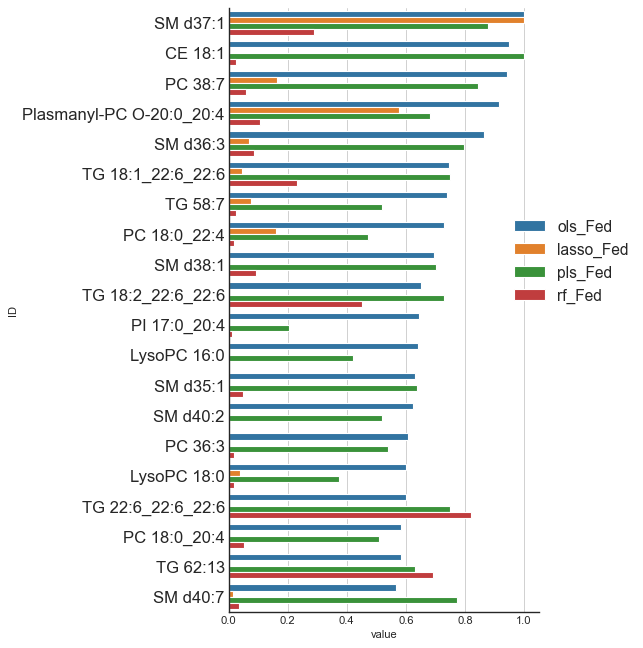

In [19]:
def plot_importance(features, sampling):

    melt = r.loc[r].melt(id_vars=['ID'], value_vars=[model+'_Fed' for model in ['ols', 'lasso', 'pls', 'rf']])  
    fig, ax = plt.subplots(figsize=(5, 10), dpi=80)
    sns.barplot(
        data=melt, x='value', y='ID', 
        orient='horizontal', hue='variable',
        dodge=True,
        ax=ax, 
    )
    plt.yticks(fontsize=15)
    plt.legend(loc=(0.9, 0.5), fontsize=14, markerscale=2)
    # plt.axvline(1, c='gray', alpha=0.7)
    plt.grid(axis='x', visible=None)
    sns.despine()

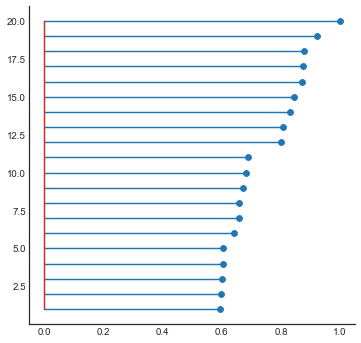

In [68]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=70)

plt.stem(r['y_point'], r['ols_Fed'], orientation='horizontal')
# plt.yticks(ticks=plt.yticks()[0], labels=r['ID'])
sns.despine()

In [46]:
18/291

0.061855670103092786

In [ ]:
plt.stem()

In [25]:
olsfed = r.loc[(r['model'] == 'ols') & (r['x'] == 'Fed')]
olsfed = olsfed[data.index].T.abs().sort_values(0, ascending=False)
olsfed

,0
m_293,146.520210
l_807,139.697373
l_803,125.541193
l_62,121.057603
m_258,120.202456
...,...
m_433,0.208395
l_532,0.205494
l_132,0.171337
l_133,0.121498


In [4]:
r = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv')

ranks = r.loc[(r['y'] == 'ogtt') \
              & (~r['model'].isin(['lasso'])),  # Dropping LASSO justifiable because only 251/1371 features 
                                                #    are nonzero, which messes up the rankings 
              data.index].abs().rank(axis=1, ascending=False)
# display(ranks)
avg_rank = ranks.loc[(r['y'] == 'ogtt') & (r['x'] == 'Fed')].mean().sort_values().to_frame('Fed')

avg_rank = avg_rank.join(ranks.loc[(r['y'] == 'ogtt') & (r['x'] == 'Fasted')].mean().to_frame('Fasted'))
avg_rank = avg_rank.join(data[['qval_fed', 'qval_fasted', 'ID']])
avg_rank.loc[:, ['qval_fed', 'qval_fasted']] = avg_rank.loc[:, ['qval_fed', 'qval_fasted']].rank(ascending=True)
ids_ranks = avg_rank.loc[avg_rank['ID'] != 'unknown']
ids_ranks.rename({'Fed': 'Avg. rank fed models', 'Fasted': 'Avg. rank fasted models',
                  'qval_fed': 'Fed linear model rank', 'qval_fasted': 'Fasted linear model rank'}, axis=1, inplace=True)
ids_ranks.iloc[:50]

C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Avg. rank fed models,Avg. rank fasted models,Fed linear model rank,Fasted linear model rank,ID
i,,,,,
l_393,18.0,794.8,24.5,1170.5,SM d37:1
l_604,48.2,236.8,12.5,139.0,TG 18:1_22:6_22:6
l_159,51.8,698.0,186.5,852.5,SM d36:3
l_461,51.8,24.4,128.0,35.0,Plasmanyl-PC O-20:0_20:4
l_150,55.6,591.6,449.5,835.0,PC 38:7
l_567,63.2,273.0,9.0,32.0,TG 18:2_22:6_22:6
m_227,70.8,625.2,672.5,1061.0,Ascorbic acid 2-sulfate
l_538,77.2,148.0,7.0,6.0,TG 22:6_22:6_22:6
l_425,80.2,802.8,313.0,1367.5,SM d38:1


In [10]:
data['qval_fed']

i
m_0      0.005399
m_1      0.000001
m_2      0.563218
m_3      0.531078
m_4      0.562464
           ...   
l_868    0.000212
l_869    0.000701
l_870    0.005132
l_871    0.001391
l_872    0.002125
Name: qval_fed, Length: 1371, dtype: float64